# Plum classification

In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
import os
import matplotlib.pyplot as plt
import random
import numpy as np
from pathlib import Path
from keras.preprocessing.image import load_img
import cv2
# encode both columns label and variety
from sklearn.preprocessing import LabelEncoder
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Advanced Data Augmentation for training
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2,
#     rotation_range=25,           # randomly rotate images by up to 25 degrees
#     width_shift_range=0.2,       # shift the image width-wise by 20%
#     height_shift_range=0.2,      # shift the image height-wise by 20%
#     shear_range=0.2,             # apply shearing transformations
#     zoom_range=0.2,              # zoom in and out by 20%
#     horizontal_flip=True,        # randomly flip images horizontally
#     fill_mode='nearest'          # fill in missing pixels after transformations
# )

# # Data generator for validation (only rescaling)
# val_datagen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2
# )


In [3]:
import kagglehub
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Download the dataset using kagglehub
dataset_dir = kagglehub.dataset_download("arnaudfadja/african-plums-quality-and-defect-assessment-data")

# The actual images are inside the 'african_plums' folder, which is in a 'versions/1' subfolder
# Fix: Removed extra 'versions/1' from the path
image_dir = os.path.join(dataset_dir, 'african_plums_dataset/african_plums')


# Load training data
train_ds = train_datagen.flow_from_directory(
    directory=image_dir, # Now this points to the correct image directory
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    subset="training",
    seed=123
)

# Load validation data
val_ds = train_datagen.flow_from_directory(
    directory=image_dir, # Now this points to the correct image directory
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    subset="validation",
    seed=123
)

100%|██████████| 290M/290M [00:05<00:00, 57.3MB/s]

Extracting files...


Found 3608 images belonging to 6 classes.
Found 899 images belonging to 6 classes.


In [7]:
import os
import shutil
import hashlib
from PIL import Image
import kagglehub
from collections import defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to calculate MD5 hash of an image
def calculate_image_hash(image_path):
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB')
            img_bytes = img.tobytes()
            return hashlib.md5(img_bytes).hexdigest()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Function to remove duplicate images
def remove_duplicate_images(image_dir):
    hash_to_files = defaultdict(list)
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                file_path = os.path.join(root, file)
                image_hash = calculate_image_hash(file_path)
                if image_hash:
                    hash_to_files[image_hash].append(file_path)

    duplicates_found = 0
    for image_hash, file_paths in hash_to_files.items():
        if len(file_paths) > 1:
            duplicates_found += len(file_paths) - 1
            for file_path in file_paths[1:]:
                print(f"Removing duplicate: {file_path}")
                try:
                    os.remove(file_path)
                except Exception as e:
                    print(f"Error removing {file_path}: {e}")

    print(f"Total duplicates removed: {duplicates_found}")
    return duplicates_found

# Download the dataset using kagglehub
dataset_dir = kagglehub.dataset_download("arnaudfadja/african-plums-quality-and-defect-assessment-data")
original_image_dir = os.path.join(dataset_dir, 'african_plums_dataset', 'african_plums')

# Copy dataset to a writable directory
writable_dir = '/kaggle/working/african_plums_cleaned'
if os.path.exists(writable_dir):
    shutil.rmtree(writable_dir)  # Clear previous copy if exists
shutil.copytree(original_image_dir, writable_dir)

# Remove duplicates from the writable directory
print(f"Processing images in: {writable_dir}")
remove_duplicate_images(writable_dir)

# Create ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Create ImageDataGenerator for validation (no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training data from cleaned directory
train_ds = train_datagen.flow_from_directory(
    directory=writable_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    subset="training",
    seed=123
)

# Load validation data from cleaned directory
val_ds = val_datagen.flow_from_directory(
    directory=writable_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    subset="validation",
    seed=123
)

# Verify the dataset
print(f"Training images: {train_ds.samples}")
print(f"Validation images: {val_ds.samples}")
print(f"Classes: {train_ds.class_indices}")

Processing images in: /kaggle/working/african_plums_cleaned
Removing duplicate: /kaggle/working/african_plums_cleaned/rotten/rotten_plum_337.png
Removing duplicate: /kaggle/working/african_plums_cleaned/rotten/rotten_plum_165.png
Removing duplicate: /kaggle/working/african_plums_cleaned/rotten/rotten_plum_331.png
Removing duplicate: /kaggle/working/african_plums_cleaned/rotten/rotten_plum_569.png
Removing duplicate: /kaggle/working/african_plums_cleaned/bruised/bruised_plum_78.png
Removing duplicate: /kaggle/working/african_plums_cleaned/rotten/rotten_plum_84.png
Removing duplicate: /kaggle/working/african_plums_cleaned/rotten/rotten_plum_638.png
Removing duplicate: /kaggle/working/african_plums_cleaned/rotten/rotten_plum_245.png
Removing duplicate: /kaggle/working/african_plums_cleaned/rotten/rotten_plum_500.png
Removing duplicate: /kaggle/working/african_plums_cleaned/rotten/rotten_plum_127.png
Removing duplicate: /kaggle/working/african_plums_cleaned/rotten/rotten_plum_222.png
Remov

In [6]:


# Define the path to the cleaned images
image_dir = os.path.join(dataset_dir, 'african_plums_dataset', 'african_plums')

# Create ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

# Create ImageDataGenerator for validation (no augmentation, just rescaling)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training data
train_ds = train_datagen.flow_from_directory(
    directory=image_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    subset="training",
    seed=123
)

# Load validation data
val_ds = val_datagen.flow_from_directory(
    directory=image_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    subset="validation",
    seed=123
)

# Verify the dataset
print(f"Training images: {train_ds.samples}")
print(f"Validation images: {val_ds.samples}")
print(f"Classes: {train_ds.class_indices}")


Found 3608 images belonging to 6 classes.
Found 899 images belonging to 6 classes.
Training images: 3608
Validation images: 899
Classes: {'bruised': 0, 'cracked': 1, 'rotten': 2, 'spotted': 3, 'unaffected': 4, 'unripe': 5}


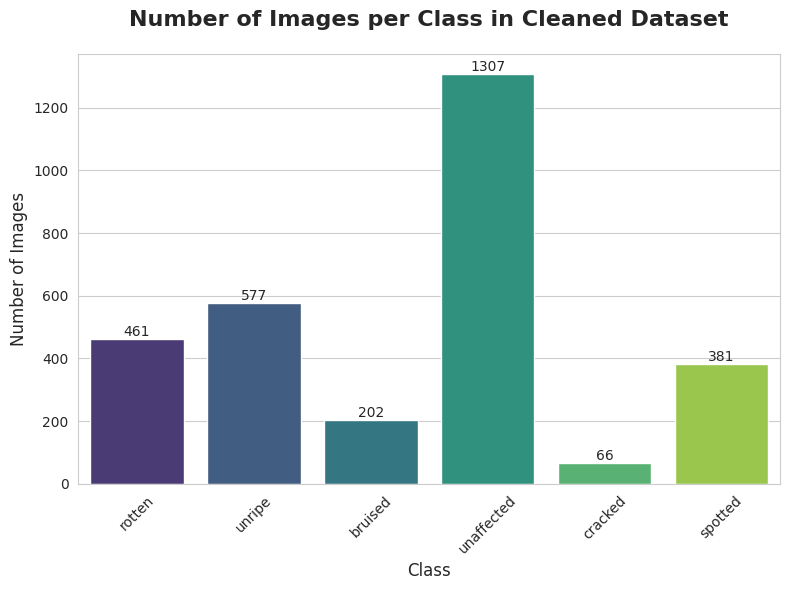

Image counts per class:
rotten: 461 images
unripe: 577 images
bruised: 202 images
unaffected: 1307 images
cracked: 66 images
spotted: 381 images


In [8]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import shutil
from collections import defaultdict

# Function to count images in each class
def count_images_per_class(image_dir):
    class_counts = defaultdict(int)
    for root, _, files in os.walk(image_dir):
        # Only count files in class subdirectories (not root directory)
        if root != image_dir:
            class_name = os.path.basename(root)
            # Count image files (with supported extensions)
            image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            class_counts[class_name] += len(image_files)
    return class_counts

# Download the dataset using kagglehub (cached if already downloaded)
dataset_dir = kagglehub.dataset_download("arnaudfadja/african-plums-quality-and-defect-assessment-data")
original_image_dir = os.path.join(dataset_dir, 'african_plums_dataset', 'african_plums')

# Use the cleaned dataset directory (assuming duplicates were removed)
cleaned_dir = '/kaggle/working/african_plums_cleaned'

# If the cleaned directory doesn't exist, copy the original dataset
# Note: This assumes duplicates were not yet removed; if they were, skip copying
if not os.path.exists(cleaned_dir):
    shutil.copytree(original_image_dir, cleaned_dir)
    # Optionally, you can add the duplicate removal function here if not already done
    # remove_duplicate_images(cleaned_dir)  # Uncomment if duplicates need to be removed

# Count images in each class
class_counts = count_images_per_class(cleaned_dir)

# Prepare data for plotting
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create a beautiful bar plot
plt.figure(figsize=(8, 6))  # Set figure size
sns.set_style("whitegrid")  # Use a clean grid style
sns.barplot(x=classes, y=counts, palette="viridis")  # Use a vibrant color palette

# Customize the plot
plt.title("Number of Images per Class in Cleaned Dataset", fontsize=16, weight='bold', pad=20)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # Rotate class names for readability
plt.yticks(fontsize=10)

# Add value labels on top of bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print the counts for reference
print("Image counts per class:")
for cls, cnt in class_counts.items():
    print(f"{cls}: {cnt} images")

Copied rotten class as-is
Copied unripe class as-is
Generated 606 images for class bruised
Kept 653 images for class unaffected
Generated 461 images for class cracked
Copied spotted class as-is


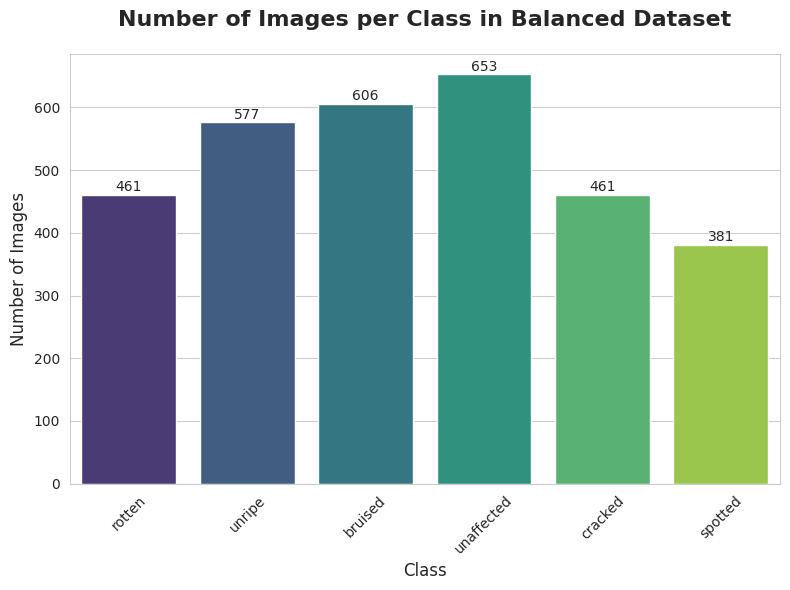

Image counts per class in balanced dataset:
rotten: 461 images
unripe: 577 images
bruised: 606 images
unaffected: 653 images
cracked: 461 images
spotted: 381 images


In [9]:
import os
import shutil
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set random seed for reproducibility
random.seed(123)
np.random.seed(123)

# Function to count images in each class
def count_images_per_class(image_dir):
    class_counts = defaultdict(int)
    for root, _, files in os.walk(image_dir):
        if root != image_dir:
            class_name = os.path.basename(root)
            image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            class_counts[class_name] += len(image_files)
    return class_counts

# Function to augment images for a specific class
def augment_images(class_dir, output_dir, augmentation_factor):
    os.makedirs(output_dir, exist_ok=True)

    # Initialize ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        fill_mode='nearest'
    )

    # Get list of images
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    num_images = len(image_files)
    num_to_generate = int(num_images * (augmentation_factor - 1))  # Number of new images to generate

    # Copy original images
    for img_file in image_files:
        shutil.copy(os.path.join(class_dir, img_file), os.path.join(output_dir, img_file))

    # Generate augmented images
    for img_file in image_files:
        img_path = os.path.join(class_dir, img_file)
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)  # Reshape for datagen

        # Generate augmented images
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_dir,
                                save_prefix=f'aug_{os.path.splitext(img_file)[0]}',
                                save_format='png'):
            i += 1
            if i >= int((augmentation_factor - 1) * num_images / len(image_files)) + 1:
                break  # Generate roughly the required number per image

    # Count final images
    final_count = len([f for f in os.listdir(output_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
    print(f"Generated {final_count} images for class {os.path.basename(class_dir)}")

# Function to reduce images for a specific class
def reduce_images(class_dir, output_dir, reduction_factor):
    os.makedirs(output_dir, exist_ok=True)

    # Get list of images
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    num_images = len(image_files)
    num_to_keep = int(num_images * reduction_factor)  # Number of images to keep

    # Randomly select images to keep
    selected_images = random.sample(image_files, num_to_keep)

    # Copy selected images
    for img_file in selected_images:
        shutil.copy(os.path.join(class_dir, img_file), os.path.join(output_dir, img_file))

    print(f"Kept {len(selected_images)} images for class {os.path.basename(class_dir)}")

# Paths
cleaned_dir = '/kaggle/working/african_plums_cleaned'
balanced_dir = '/kaggle/working/african_plums_balanced'

# Create balanced directory
if os.path.exists(balanced_dir):
    shutil.rmtree(balanced_dir)
os.makedirs(balanced_dir)

# Process each class
for class_name in os.listdir(cleaned_dir):
    class_dir = os.path.join(cleaned_dir, class_name)
    output_class_dir = os.path.join(balanced_dir, class_name)

    if os.path.isdir(class_dir):
        if class_name == 'bruised':
            augment_images(class_dir, output_class_dir, augmentation_factor=2)
        elif class_name == 'cracked':
            augment_images(class_dir, output_class_dir, augmentation_factor=6)
        elif class_name == 'unaffected':
            reduce_images(class_dir, output_class_dir, reduction_factor=0.5)
        else:
            # Copy other classes as-is
            shutil.copytree(class_dir, output_class_dir)
            print(f"Copied {class_name} class as-is")

# Count images in balanced dataset
class_counts = count_images_per_class(balanced_dir)

# Prepare data for plotting
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create a beautiful bar plot
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(x=classes, y=counts, palette="viridis")

# Customize the plot
plt.title("Number of Images per Class in Balanced Dataset", fontsize=16, weight='bold', pad=20)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Add value labels on top of bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

# Adjust layout
plt.tight_layout()

# Save and show the plot
plt.savefig('balanced_class_distribution.png')
plt.show()

# Print the counts
print("Image counts per class in balanced dataset:")
for cls, cnt in class_counts.items():
    print(f"{cls}: {cnt} images")

Class rotten: 345 train, 116 validation
Class unripe: 432 train, 145 validation
Class bruised: 454 train, 152 validation
Class unaffected: 489 train, 164 validation
Class cracked: 345 train, 116 validation
Class spotted: 285 train, 96 validation


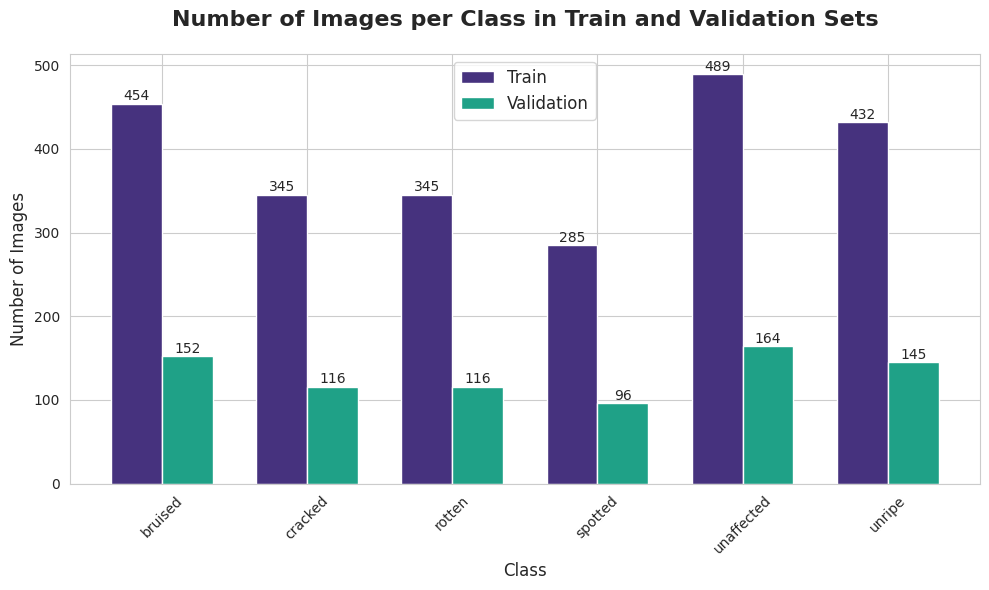


Train set counts:
rotten: 345 images
unripe: 432 images
bruised: 454 images
unaffected: 489 images
cracked: 345 images
spotted: 285 images

Validation set counts:
rotten: 116 images
unripe: 145 images
bruised: 152 images
unaffected: 164 images
cracked: 116 images
spotted: 96 images


In [10]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set random seed for reproducibility
random.seed(123)

# Function to count images in each class
def count_images_per_class(image_dir):
    class_counts = defaultdict(int)
    for root, _, files in os.walk(image_dir):
        if root != image_dir:
            class_name = os.path.basename(root)
            image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            class_counts[class_name] += len(image_files)
    return class_counts

# Function to split dataset into train and validation sets
def split_dataset(input_dir, train_dir, val_dir, train_split=0.75):
    # Create train and validation directories
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(val_dir):
        shutil.rmtree(val_dir)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Process each class
    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)
        if os.path.isdir(class_dir):
            # Create class subdirectories in train and validation
            train_class_dir = os.path.join(train_dir, class_name)
            val_class_dir = os.path.join(val_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(val_class_dir, exist_ok=True)

            # Get list of images
            image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            random.shuffle(image_files)  # Shuffle for random split

            # Calculate split index
            num_images = len(image_files)
            num_train = int(num_images * train_split)

            # Split images
            train_images = image_files[:num_train]
            val_images = image_files[num_train:]

            # Copy images to train directory
            for img_file in train_images:
                shutil.copy(os.path.join(class_dir, img_file), os.path.join(train_class_dir, img_file))

            # Copy images to validation directory
            for img_file in val_images:
                shutil.copy(os.path.join(class_dir, img_file), os.path.join(val_class_dir, img_file))

            print(f"Class {class_name}: {len(train_images)} train, {len(val_images)} validation")

# Paths
balanced_dir = '/kaggle/working/african_plums_balanced'
train_dir = '/kaggle/working/african_plums_train'
val_dir = '/kaggle/working/african_plums_val'

# Split the dataset
split_dataset(balanced_dir, train_dir, val_dir, train_split=0.75)

# Count images in train and validation sets
train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)

# Prepare data for plotting
classes = sorted(set(train_counts.keys()).union(set(val_counts.keys())))
train_data = [train_counts.get(cls, 0) for cls in classes]
val_data = [val_counts.get(cls, 0) for cls in classes]

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
bar_width = 0.35
x = np.arange(len(classes))

# Plot bars
plt.bar(x - bar_width/2, train_data, bar_width, label='Train', color=sns.color_palette("viridis")[0])
plt.bar(x + bar_width/2, val_data, bar_width, label='Validation', color=sns.color_palette("viridis")[3])

# Customize the plot
plt.title("Number of Images per Class in Train and Validation Sets", fontsize=16, weight='bold', pad=20)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(x, classes, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

# Add value labels on top of bars
for i, (train_count, val_count) in enumerate(zip(train_data, val_data)):
    if train_count > 0:
        plt.text(i - bar_width/2, train_count + 0.5, str(train_count), ha='center', va='bottom', fontsize=10)
    if val_count > 0:
        plt.text(i + bar_width/2, val_count + 0.5, str(val_count), ha='center', va='bottom', fontsize=10)

# Adjust layout
plt.tight_layout()

# Save and show the plot
plt.savefig('train_val_class_distribution.png')
plt.show()

# Print the counts
print("\nTrain set counts:")
for cls, cnt in train_counts.items():
    print(f"{cls}: {cnt} images")
print("\nValidation set counts:")
for cls, cnt in val_counts.items():
    print(f"{cls}: {cnt} images")

In [17]:
# prompt: install tfimm

!pip install timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [15]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import tfimm  # TensorFlow-compatible timm for ReXNet

# Set random seed for reproducibility
tf.random.set_seed(123)
np.random.seed(123)

# Paths to train and validation directories
train_dir = '/kaggle/working/african_plums_train'
val_dir = '/kaggle/working/african_plums_val'

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation data
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class names and number of classes
class_names = list(train_ds.class_indices.keys())  # ['bruised', 'cracked', 'unaffected']
num_classes = len(class_names)

# Load pre-trained ReXNet model using tfimm
base_model = tfimm.create_model('rexnet_100', pretrained=True, in_channels=3)

# Freeze the base model
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Train the model
num_epochs = 10
history = model.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=val_ds,
    verbose=1
)

# Save the model
model.save('/kaggle/working/rexnet_plum_classifier.h5')

# Evaluate on validation set for confusion matrix and classification report
val_images, val_labels = next(val_ds)  # Get one batch for simplicity; adjust for full dataset
val_preds = model.predict(val_ds)
val_preds_classes = np.argmax(val_preds, axis=1)
val_labels_classes = np.argmax(val_labels, axis=1)

# Plot training metrics
plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color=sns.color_palette("viridis")[0])
plt.plot(history.history['val_loss'], label='Validation Loss', color=sns.color_palette("viridis")[3])
plt.title("Training and Validation Loss", fontsize=14, weight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color=sns.color_palette("viridis")[0])
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color=sns.color_palette("viridis")[3])
plt.title("Training and Validation Accuracy", fontsize=14, weight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.savefig('/kaggle/working/training_metrics_tf.png')
plt.show()

# Confusion matrix
cm = confusion_matrix(val_labels_classes, val_preds_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix", fontsize=14, weight='bold')
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.savefig('/kaggle/working/confusion_matrix_tf.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(val_labels_classes, val_preds_classes, target_names=class_names))

ModuleNotFoundError: No module named 'tfimm'

In [ ]:
# import matplotlib.pyplot as plt
# import random
# import os
# from PIL import Image

# def visualize_images(folder_path, num_images=5):
#     images = os.listdir(folder_path)
#     selected_images = random.sample(images, min(num_images, len(images)))

#     plt.figure(figsize=(15, 5))

#     for i, image_name in enumerate(selected_images):
#         image_path = os.path.join(folder_path, image_name)
#         img = Image.open(image_path)
#         plt.subplot(1, num_images, i + 1)
#         plt.imshow(img)
#         plt.title(image_name)
#         plt.axis('off')

#     plt.tight_layout()
#     plt.show()


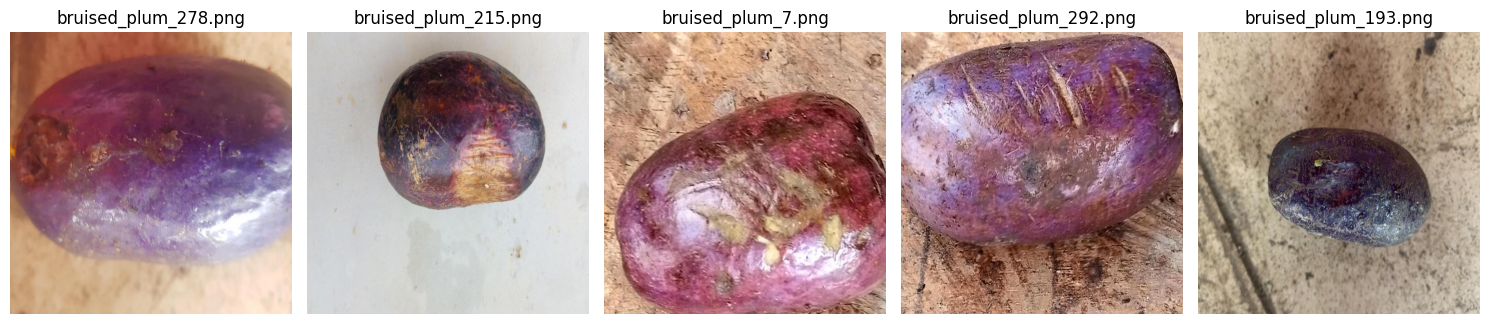

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = f'{image_dir}/bruised'

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)


In [13]:
# # Specify the path containing the images to visualize
# path_to_visualize = f'{image_dir}/cracked'

# # Visualize 5 random images
# visualize_images(path_to_visualize, num_images=5)


NameError: name 'visualize_images' is not defined

In [14]:
# # Specify the path containing the images to visualize
# path_to_visualize = f'{image_dir}/rotten'

# # Visualize 5 random images
# visualize_images(path_to_visualize, num_images=5)


NameError: name 'visualize_images' is not defined

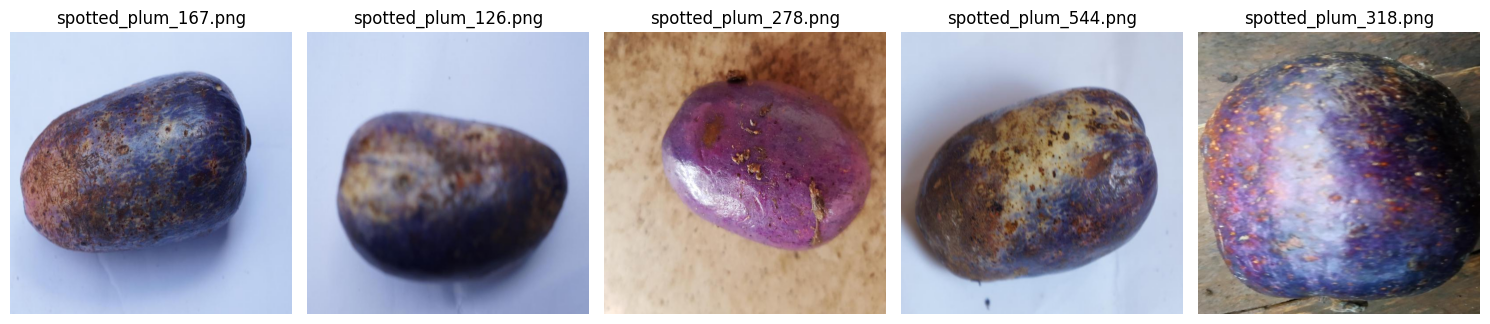

In [ ]:
# # Specify the path containing the images to visualize
# path_to_visualize = f'{image_dir}/spotted'
# #
# # Visualize 5 random images
# visualize_images(path_to_visualize, num_images=5)


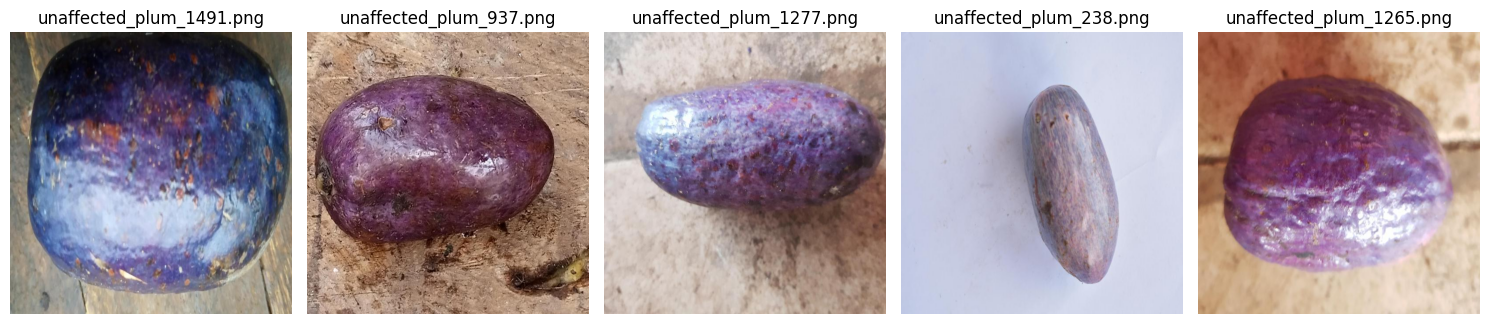

In [ ]:
# # Specify the path containing the images to visualize
# path_to_visualize = f'{image_dir}/unaffected'

# # Visualize 5 random images
# visualize_images(path_to_visualize, num_images=5)


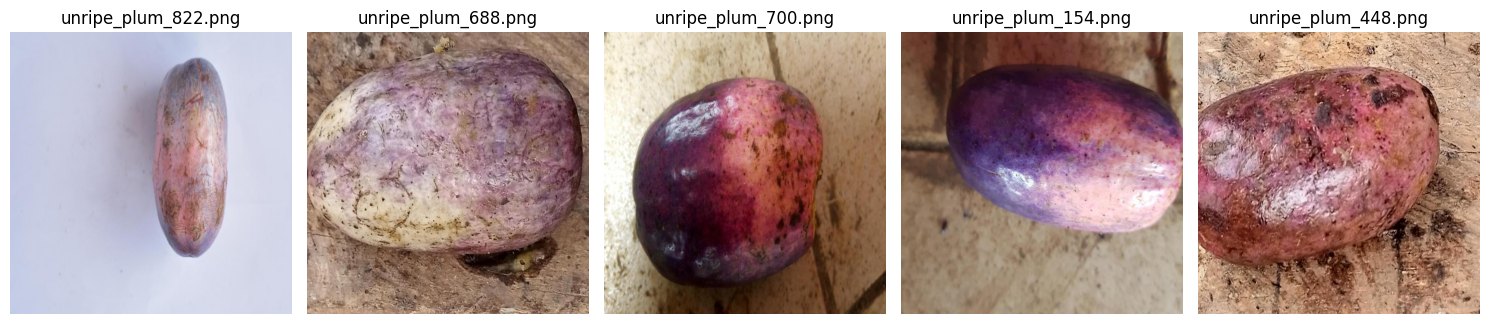

In [ ]:
# # Specify the path containing the images to visualize
# path_to_visualize = f'{image_dir}/unripe'

# # Visualize 5 random images
# visualize_images(path_to_visualize, num_images=5)


In [ ]:
# from tensorflow.keras.applications import EfficientNetV2M
# from tensorflow.keras import layers, models

# # Load pre-trained model
# base_model = EfficientNetV2M(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(224, 224, 3),  # Higher resolution for better accuracy
#     pooling='avg'
# )
# base_model.trainable = True  # Fine-tune all layer

In [ ]:

# model = models.Sequential([
#     base_model,
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(6, activation='softmax')
# ])

In [ ]:
# model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-m (Functional)        │ (None, 1280)                │      53,150,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,809,338 (205.27 MB)

 Trainable params: 53,517,306 (204.15 MB)

 Non-trainable params: 292,032 (1.11 MB)

In [ ]:
# from tensorflow.keras.optimizers import Adam

# model.compile(
#     optimizer=Adam(learning_rate=1e-4),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )



In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
#     ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)
# ]


In [ ]:
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10,
#     callbacks=callbacks
# )


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 96s 845ms/step - accuracy: 0.8340 - loss: 0.4624 - val_accuracy: 0.5350 - val_loss: 1.9821
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 147s 889ms/step - accuracy: 0.8238 - loss: 0.4652 - val_accuracy: 0.4483 - val_loss: 1.6892
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 93s 817ms/step - accuracy: 0.8602 - loss: 0.3847 - val_accuracy: 0.4894 - val_loss: 1.7024
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 93s 825ms/step - accuracy: 0.8610 - loss: 0.3853 - val_accuracy: 0.5473 - val_loss: 1.5219
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 93s 824ms/step - accuracy: 0.8652 - loss: 0.3469 - val_accuracy: 0.4983 - val_loss: 1.5219
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 94s 827ms/step - accuracy: 0.8766 - loss: 0.3215 - val_accuracy: 0.5996 - val_loss: 1.4282
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 97s 862ms/step - accuracy: 0.8817 - loss: 0.3169 - val_accuracy: 0.6218 - val_loss: 1.5738
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 97s 860ms/step - accuracy: 0.8884 - loss: 

29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 524ms/step - accuracy: 0.6132 - loss: 1.2254


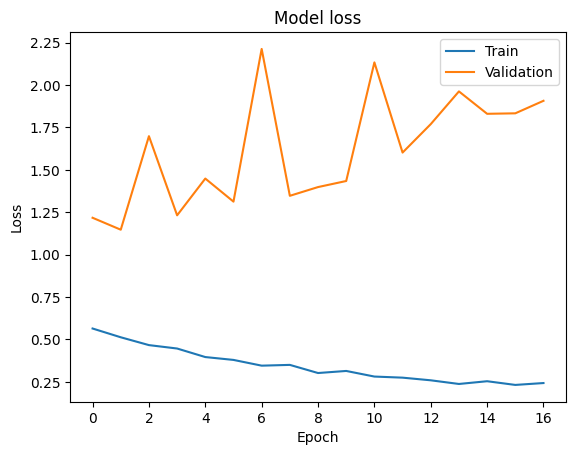

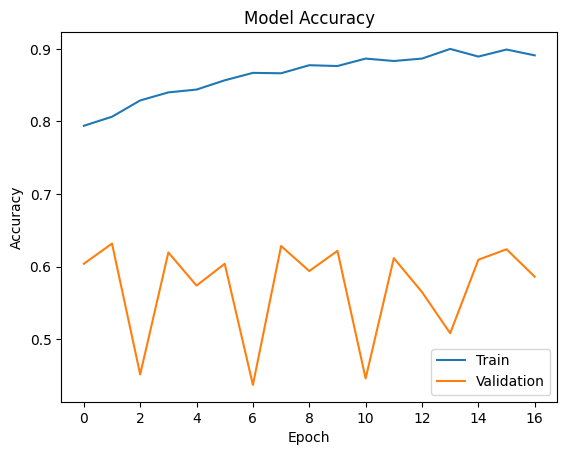

In [ ]:
# # evaluate the model
# loss = model.evaluate(val_ds)

# # Plotting the training and testing loss
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.show()

# # plot the accuracy of training and validation

# # Plotting the training and validation accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='lower right')
# plt.show()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive
